# modeling ecological priors

An ecological prior for a scene takes into account what species are likely for a particular scene based on membership in a visual cluster. The cluster provides information about what species are likely to be present in the scene.

We can infer the ecological prior via bayesian modeling. We have the following peices of information from the test dataset:

- roughly 2k images each with an embedding from a trained ViT model and predicted species logits.
- when clustered in embedding space, there are 3 visually distinct clusters that are evenly distributed. These clusters are composed of disjoint longitudinal quadrat plot studies.

From the train dataset, we can summarize some prior information for each species for modeling:

- the number of times it appears in the training dataset
- what genus and family the species belongs to
- the average and stdev of the altitude (nullable)
- whether it appears in france/spain (nullable)
- the visual similarity to the test clusters

We use this information to build a heirachical bayesian model that predicts the probability of a species being present given the cluster it belongs to. We can use this result to then reweight the logits from the ViT model to get a more accurate prediction of species present in a test scene via bayesian inference using the ecological prior.

The modeling also gives us other useful information such as the most likely species, genus, and  for each cluster. We can infer what the average altitude is for each cluster. 

## modeling

So there is some prior information that needs to go into this.

```mermaid
graph TD

  %% Taxonomy hierarchy
  family["family"] --> genus["genus"]
  genus --> species["species"]

  %% Trait inputs
  species --> altitude["altitude[s]"]
  species --> presence["presence[s]"]

  %% Cluster membership
  species --> cluster["cluster assignment (from image)"]

  %% Optional: cluster-specific species prior
  cluster --> pi["π(s | cluster)"]

  %% Traits influencing prior
  altitude --> pi
  presence --> pi
  genus --> pi
```

We can do heirachical modeling to impute missing information that we might have around things like altitude or presence in a country.

```mermaid
graph TD

    %% Family-level priors
    subgraph "Family-level (for each family f)"
        mu_family["μ_family[f] ~ Normal(μ₀, σ₀)"]
        sigma_family["σ_family[f] ~ Exponential(λ)"]
    end

    %% Genus-level priors, dependent on family
    subgraph "Genus-level (for each genus g)"
        mu_genus["μ_genus[g] ~ Normal(μ_family[f], σ_family[f])"]
        sigma_genus["σ_genus[g] ~ Exponential(λ)"]
    end

    %% Species-level trait, dependent on genus
    subgraph "Species-level (for each species s)"
        altitude["altitude[s] ~ Normal(μ_genus[g], σ_genus[g])"]
        altitude_obs["altitude_obs[s] ~ Normal(altitude[s], σ_obs)"]
    end

    %% Arrows
    mu_family --> mu_genus
    sigma_family --> mu_genus
    mu_family --> sigma_genus
    sigma_family --> sigma_genus

    mu_genus --> altitude
    sigma_genus --> altitude
    altitude --> altitude_obs
```

In [ ]:
from pathlib import Path
from plantclef.spark import get_spark
from pyspark.sql import functions as F

import pacmap
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.pipeline import Pipeline

In [2]:
spark = get_spark(cores=8, memory="24g")
spark

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/04/15 23:29:38 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/04/15 23:29:38 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


## test dataset

- TODO: we don't have the embeddings for the test dataset, which I would like.

In [25]:
data_root = Path("~/shared/plantclef/data").expanduser()
test = spark.read.parquet(f"{data_root}/embeddings/test_2025/test_2025_embed_logits")
test.printSchema()

root
 |-- image_name: string (nullable = true)
 |-- output: struct (nullable = true)
 |    |-- cls_token: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |    |-- logits: array (nullable = true)
 |    |    |-- element: float (containsNull = true)
 |-- sample_id: integer (nullable = true)



Let's use pacmap to get three clusters, and then assign each image to a cluster based on the embedding.

In [61]:
X = np.stack(
    test.orderBy("image_name").select("output.cls_token").toPandas().cls_token.values
)
X.shape

(2105, 768)

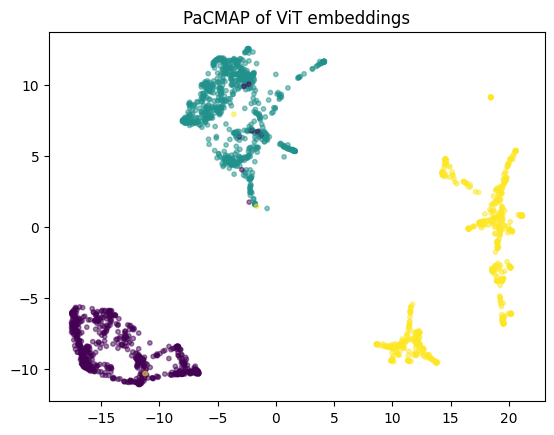

In [62]:
pipeline = Pipeline(
    [
        ("reducer", pacmap.PaCMAP(n_components=2, save_tree=True)),
        ("kmeans", KMeans(n_clusters=3)),
    ]
)
pipeline.fit(X)
emb = pipeline.named_steps["reducer"].transform(X)
labels = pipeline.named_steps["kmeans"].labels_
plt.scatter(emb[:, 0], emb[:, 1], s=10, alpha=0.5, c=labels, cmap="viridis")
plt.title("PaCMAP of ViT embeddings")
plt.show()

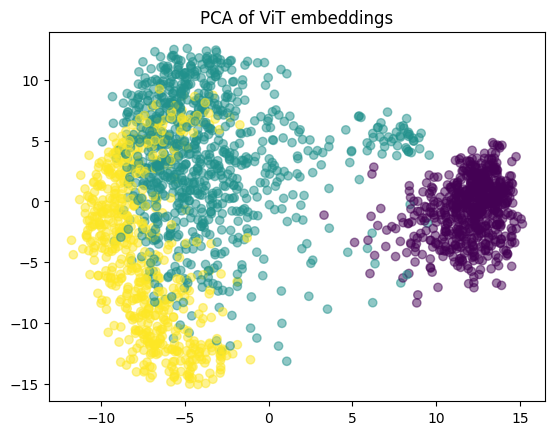

In [60]:
reducer = PCA(n_components=2)
emb = reducer.fit_transform(X)
plt.scatter(emb[:, 0], emb[:, 1], alpha=0.5, c=labels, cmap="viridis")
plt.title("PCA of ViT embeddings")
plt.show()

In [76]:
# let's merge this information back into the original dataset
cluster_df = pd.DataFrame(
    {
        "image_name": test.orderBy("image_name")
        .select("image_name")
        .toPandas()
        .image_name,
        "cluster_id": labels,
    }
)


@F.udf("array<double>")
def softmax(arr: list[float]) -> list[float]:
    """Softmax function applied to a list of floats."""
    return (np.exp(arr) / np.sum(np.exp(arr))).tolist()


@F.udf("array<double>")
def mean_array(arr: list[list[float]]) -> list[float]:
    return np.mean(arr, axis=0).tolist()


@F.udf("array<double>")
def normalize_array(arr: list[float]) -> list[float]:
    """Make probabilities sum to 1."""
    arr = np.array(arr)
    return (arr / np.sum(arr)).tolist()


# using clusters as our prior information
agg_test = (
    test.join(
        spark.createDataFrame(cluster_df),
        on="image_name",
    )
    .groupby("cluster_id")
    .agg(
        mean_array(F.collect_list("output.cls_token")).alias("mean_cls_token"),
        normalize_array(mean_array(softmax(F.collect_list("output.logits")))).alias(
            "mean_proba"
        ),
    )
    .orderBy("cluster_id")
).cache()
agg_test.printSchema()
agg_test.show(vertical=True, truncate=80)

root
 |-- cluster_id: integer (nullable = true)
 |-- mean_cls_token: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- mean_proba: array (nullable = true)
 |    |-- element: double (containsNull = true)



-RECORD 0------------------------------------------------------------------------------------------
 cluster_id     | 0                                                                                
 mean_cls_token | [0.2663275523752071, 1.221571081928345, -0.6126612470756718, 0.22401837302647... 
 mean_proba     | [2.058140525858976E-5, 1.8602867426438037E-5, 1.2635691335349584E-5, 6.526754... 
-RECORD 1------------------------------------------------------------------------------------------
 cluster_id     | 1                                                                                
 mean_cls_token | [0.2294259711191157, 1.3598360288844544, -1.3061285973804952, 0.2546373724608... 
 mean_proba     | [1.9375739044680752E-5, 3.0886118143338024E-5, 2.9774334625811835E-5, 1.28060... 
-RECORD 2------------------------------------------------------------------------------------------
 cluster_id     | 2                                                                                


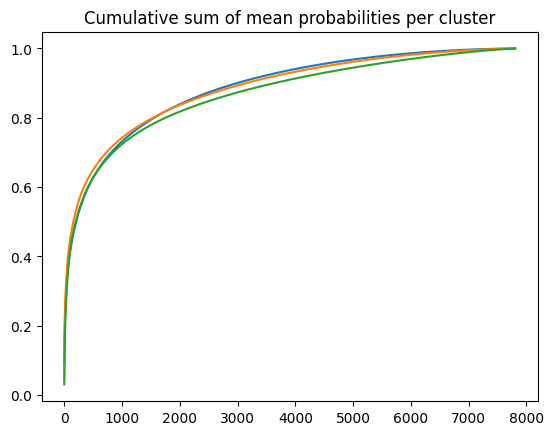

In [79]:
for row in agg_test.collect():
    plt.plot(np.cumsum(sorted(row.mean_proba, reverse=True)))
plt.title("Cumulative sum of mean probabilities per cluster")
plt.show()

### train dataset

This is where we get the ecological information from. We'll have to infer a bunch of things, but first let's get a clearer picture.

In [4]:
train = spark.read.parquet(f"{data_root}/parquet/train")
train.printSchema()

root
 |-- image_name: string (nullable = true)
 |-- path: string (nullable = true)
 |-- data: binary (nullable = true)
 |-- organ: string (nullable = true)
 |-- species_id: integer (nullable = true)
 |-- obs_id: long (nullable = true)
 |-- license: string (nullable = true)
 |-- partner: string (nullable = true)
 |-- author: string (nullable = true)
 |-- altitude: double (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- gbif_species_id: string (nullable = true)
 |-- species: string (nullable = true)
 |-- genus: string (nullable = true)
 |-- family: string (nullable = true)
 |-- dataset: string (nullable = true)
 |-- publisher: string (nullable = true)
 |-- references: string (nullable = true)
 |-- url: string (nullable = true)
 |-- learn_tag: string (nullable = true)
 |-- image_backup_url: string (nullable = true)



In [5]:
train.show(n=1, vertical=True, truncate=100)

-RECORD 0----------------------------------------------------------------------------------------------------------------
 image_name       | 0703b7eb2951080a51aba745682d353c2cc71aff.jpg                                                         
 path             | /PlantCLEF2024/train/1737493/0703b7eb2951080a51aba745682d353c2cc71aff.jpg                            
 data             | [FF D8 FF E0 00 10 4A 46 49 46 00 01 01 00 00 01 00 01 00 00 FF DB 00 43 00 08 06 06 07 06 05 08 ... 
 organ            | leaf                                                                                                 
 species_id       | 1737493                                                                                              
 obs_id           | 1014839418                                                                                           
 license          | cc-by-sa                                                                                             
 partner          | NULL

The organ is interesting, although for most plants we might not actually have an image of all of these. These might be indicative of morphological traits that we can use in our prior.

In [6]:
train.groupBy("organ").count().show()

+------+------+
| organ| count|
+------+------+
|flower|389251|
|  scan|  8204|
| fruit|165855|
| habit|355732|
|  leaf|340852|
|branch| 59632|
|  bark| 88507|
+------+------+



For now, let's just get the frequency and altitude.

TODO: come back here and add information about the longitude and latitude. This will likely be distance to certain locations. We can't really model this directly, but we can use some sort of categorical or bernoulli prior to indicate whether the species is present at all in a location. Perhaps this is used to infer whether it is present in a cluster?

In [ ]:
# how many of the rows are missing some kind of information?
group = ["species_id", "species", "genus", "family"]
df = train.groupBy(group[0]).agg(
    F.mean("altitude").alias("altitude"),
    F.mean("latitude").alias("latitude"),
    F.mean("longitude").alias("longitude"),
    F.count("species_id").alias("count"),
)
df.summary().show(vertical=True)

# NOTE: if one is missing, all of them are missing
(
    df.select(
        F.expr("sum(cast(altitude is null as int))/count(*)").alias("altitude_null"),
        F.expr("sum(cast(latitude is null as int))/count(*)").alias("latitude_null"),
        F.expr("sum(cast(longitude is null as int))/count(*)").alias("longitude_null"),
        F.expr(
            "sum(cast(latitude is null and longitude is null as int))/count(*)"
        ).alias("latlong_null"),
        # and now all three null
        F.expr(
            "sum(cast(altitude is null and latitude is null and longitude is null as int))/count(*)"
        ).alias("all_null"),
    )
).show(vertical=True)

-RECORD 0--------------------------
 summary    | count                
 species_id | 7806                 
 altitude   | 6208                 
 latitude   | 6208                 
 longitude  | 6208                 
 count      | 7806                 
-RECORD 1--------------------------
 summary    | mean                 
 species_id | 1450859.982065078    
 altitude   | 4235.489673367421    
 latitude   | 42.10826236896807    
 longitude  | 201.15277340725294   
 count      | 180.37829874455548   
-RECORD 2--------------------------
 summary    | stddev               
 species_id | 132331.98634398048   
 altitude   | 288424.7753522965    
 latitude   | 8.651058240204774    
 longitude  | 2917.8620194962273   
 count      | 149.85157973554573   
-RECORD 3--------------------------
 summary    | min                  
 species_id | 1355868              
 altitude   | -47.7                
 latitude   | -38.3589963          
 longitude  | -120.59306603        
 count      | 1             

-RECORD 0-----------------------------
 altitude_null  | 0.20471432231616704 
 latitude_null  | 0.20471432231616704 
 longitude_null | 0.20471432231616704 
 latlong_null   | 0.20471432231616704 
 all_null       | 0.20471432231616704 



## heirachical modeling

The simplest possible model that can do at this point is to determine what the altitude of each of the species is, using heirarchical modeling to impute missing data. We can then use this to determine the average altitude of each cluster, which can then be used to reweight the logits from the ViT model.

The intution is that species that are probable among the same cluster of images are likely to have similar altitudes. A species are more probable if they are in the same altitude band as the cluster. When we don't know the altitude of a species, we can use both prior we get from the genus and the family to impute the altitude of the species. The physical meaning is helpful for us to narrow down the range since altitude affects presence.

In [21]:
test.printSchema()

root
 |-- dominant_cluster: integer (nullable = true)
 |-- renormalized_probabilities: array (nullable = true)
 |    |-- element: float (containsNull = true)



In [19]:
group = ["species_id", "species", "genus", "family"]
input_df = (
    train.groupBy(*group)
    .agg(
        F.mean("altitude").alias("mean_altitude"),
        F.std("altitude").alias("std_altitude"),
        F.count("*").alias("observations"),
    )
    .orderBy("species_id")
)
input_df.show()
input_df = input_df.toPandas()

+----------+--------------------+-----------+----------+------------------+------------------+------------+
|species_id|             species|      genus|    family|     mean_altitude|      std_altitude|observations|
+----------+--------------------+-----------+----------+------------------+------------------+------------+
|   1355868|   Lactuca virosa L.|    Lactuca|Asteraceae| 236.9663170731707|287.47067071987584|         323|
|   1355869|Crepis capillaris...|     Crepis|Asteraceae| 214.7996706896552| 236.6016554942799|         412|
|   1355870|   Crepis foetida L.|     Crepis|Asteraceae|295.61411111111113|302.23685975885655|         439|
|   1355871|Hypochaeris glabr...|Hypochaeris|Asteraceae|235.73446648936172|283.92354885692293|         290|
|   1355872|Hypochaeris radic...|Hypochaeris|Asteraceae|284.17055548961423| 391.7089814294153|         464|
|   1355873|Arctotis venusta ...|   Arctotis|Asteraceae|         416.77635|407.89377999469065|          98|
|   1355880|Carduus macrocep

In [20]:
input_df

,species_id,species,genus,family,mean_altitude,std_altitude,observations
0,1355868,Lactuca virosa L.,Lactuca,Asteraceae,236.966317,287.470671,323
1,1355869,Crepis capillaris (L.) Wallr.,Crepis,Asteraceae,214.799671,236.601655,412
2,1355870,Crepis foetida L.,Crepis,Asteraceae,295.614111,302.236860,439
3,1355871,Hypochaeris glabra L.,Hypochaeris,Asteraceae,235.734466,283.923549,290
4,1355872,Hypochaeris radicata L.,Hypochaeris,Asteraceae,284.170555,391.708981,464
...,...,...,...,...,...,...,...
7853,1744890,Valeriana nevadensis (Boiss.) Christenh. & Byng,Valeriana,Caprifoliaceae,413.357900,13.236505,7
7854,1744899,Parasenegalia visco (Lorentz ex Griseb.) Seigl...,Parasenegalia,Fabaceae,311.224771,480.821362,98
7855,1744928,Eryngium ilicifolium Desf.,Eryngium,Apiaceae,503.225867,336.802434,79
7856,1744936,"Gelasia albicans (Coss.) Zaika, Sukhor. & N.Ki...",Gelasia,Asteraceae,NaN,NaN,5
